# Enhancing Product Discovery in Exhibition üìà

<!-- <font size=+3><center><b>Telco Churn Prediction with ML Insights üìà</b></center></font> -->
<img src=".\rec.png" style="float: center;" width="360" height="360" />
<span style="font-size: 12px;"><center><em>Photo by NVIDIA</em></center></span>
<span style="font-size: 20px;"><left><b>Table of Contents</b></left></span>

- [Introduction](#Introduction)
- [Objective](#Objective)
- [Libraries](#Libraries)
- [Default Setting](#Default-Setting)
- [Functions](#Functions)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
    - [Data Attributes](#Dataset-Attributes)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Preprocessing](#Data-Preprocessing)
    - [Encoding Categorical Features](#Encoding-Categorical-Features)
    - [Text Encoding](#Text-Encoding)
- [Recommendation Model Building](#Recommendation-Model-Building)
    - [Experiment and Parameter Tuning](#Experiment-and-Parameter-Tuning)
    - [Recommend Top K](#Recommend-Top-K)
- [Future Development](#Future-Development)
- [Conclusions](#Conclusions)

# Introduciton

In the dynamic exhibition industry, attendees often face the challenge of efficiently discovering relevant products amidst a vast array of offerings. To address this issue, recommendation systems have gained significant attention for their ability to provide personalized suggestions based on user preferences. In this research, we aim to develop an item-based recommendation model tailored to the exhibition industry, leveraging the text descriptions of products available. By analyzing these features, our model will enable attendees to find products that closely align with their interests and recommend similar items, thereby enhancing the overall exhibition experience.

# Objective

In this case, the absence of explicit labels and user information poses a challenge for building effective recommendation models. This research aims to develop an item-based recommendation model using product features, leveraging unsupervised learning techniques to overcome the absence of labels and limited user information. By addressing this problem, the study aims to enhance product discovery and facilitate meaningful connections between attendees and exhibitors in the exhibition industry.

In this project, I would like to answer intriguing questions that I have discovered:

* What are the key product features that significantly influence the relevance and similarity of items within the exhibition industry? How can the item-based recommendation model effectively utilize these product features?
* What are the suitable similarity analysis techniques and algorithms that can measure item similarity based on the available product features?
* How can machine learning techniques be employed to train the item-based recommendation model using the exhibition industry's product feature dataset?
* What are the challenges and techniques involved in extracting relevant information from the text descriptions of products to enhance the recommendation model?
* How can the performance and accuracy of the recommendation model be evaluated and measured in the context of the exhibition industry, considering the absence of explicit labels?

# Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Write/Read Excel 
import openpyxl

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# Sentence BERT
from sentence_transformers import SentenceTransformer, util
print('‚úîÔ∏è Libraries Imported!')

# Save the dictionary
import pickle

‚úîÔ∏è Libraries Imported!


# Default Setting

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

font_size = 18
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

# colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
# colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
# scoring_metric = 'recall'
# comparison_dict, comparison_test_dict = {}, {}

print('‚úîÔ∏è Default Setting Done!')

‚úîÔ∏è Default Setting Done!


# Functions

## normalize_embedding()

In [3]:
def normalize_embedding(embedding, norm=2):
    '''
    Normalize the input embedding vector.

    Args:
        embedding (numpy.ndarray): 
            The input embedding vector to be normalized.
        
        norm (int, default=2): 
            The order of the norm to be applied for normalization.
        
    Returns:
        numpy.ndarray:
            The normalized embedding vector.
    '''
    embedding = embedding / np.linalg.norm(embedding, ord=norm)
    return embedding

## recommend_top_k(product_id, k, threshold)

In [4]:
def recommend_top_k(product_id: int, k: int, threshold: float) -> tuple:
    '''
    Recommend the top k similar products given a product ID.

    Args:
        product_id (int): 
            The ID of the product for which recommendations will be generated.

        k (int): 
            The number of top similar products to recommend.

        threshold (float): 
            The threshold value for similarity scores. 
            Only recommendations with scores equal to or greater than this threshold will be considered.

    Returns:
        tuple:
            A tuple containing two lists:
            - The recommended product IDs.
            - The corresponding similarity scores.
            - The row indices of the recommended products as a list.

    Example:
        rec_pd_ids, rec_scores, rec_row_indices = recommend_top_k(CU0004601801, 5)
    '''
    

    row_index = df[df['Product_id'] == product_id].index
    # the reason for using k+1 is because the given item will be recommended
    rec_k_dic = util.semantic_search(embedding[row_index], embedding, top_k=k+1)[0] 
    # drop the given item itself
    rec_k_dic = np.delete(rec_k_dic, 0)
    rec_row_idx = []
    rec_score_ls = []
    for item in rec_k_dic:
        score = round(item['score'], 3)
        if score >= threshold:
            rec_row_idx.append(item['corpus_id'])
            rec_score_ls.append(round(item['score'], 3)) 

    rec_pd_id_ls = np.array(df.loc[rec_row_idx, 'Product_id'])
    return (rec_pd_id_ls, rec_score_ls, rec_row_idx)

# A Quick Look at our Data

## Dataset Attributes

- **Product_id**: The unique ID of the product.
- **Product_Name**: The name or title of the product in Chinese.
- **Vendor_id**: The unique ID of the vendor.
- **Main_Category**: The main category or exhibition type of the product.
- **Sub_Category**: The sub-category or specific category of the product.
- **Description**: The text description of the product in Chinese.
- **Product_Name_en**: The name or title of the product in English.
- **Description_en**: The text description of the product in English.

In [5]:
df = pd.read_excel('./Data/Product_20230702.xlsx', header=0, skiprows=[0,2,3,4])

print('‚úîÔ∏è Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

‚úîÔ∏è Dataset Imported Successfully!

It contains 977 rows and 28 columns.


In [6]:
df.head()

Ë™ûÁ≥ª*         Áî¢ÂìÅID*       Áî¢ÂìÅÂêçÁ®±* Ëá™ÂÆöÈóúÈçµÂ≠ó(ÈÄóÈªûÈöîÈñã)  ÊòØÂê¶Ë¶ÅË≤ºÊ®ô      Â∫´Â≠òÁãÄÊ≥Å    ÂÆöÂÉπ    ÂîÆÂÉπ  \
0  tw  CU0004601801     PE ‰øÆË£úËÜ†Â∏∂         NaN    1.0  in_stock  99.0  99.0   
1  tw  CU0004601802  C+ ÁîüÁâ©ÂèØÂàÜËß£ËÜ†Â∏∂         NaN    1.0  in_stock  99.0  99.0   
2  tw  CU0004601803    PVC Êé•Ê¢®ËÜ†Â∏∂         NaN    1.0  in_stock  99.0  99.0   
3  tw  CU0004601804    PVC Êé•Ê¢®ËÜ†Â∏∂         NaN    1.0  in_stock  99.0  99.0   
4  tw  CU0004601805     ÂõûÊî∂PETËÜ†Â∏∂         NaN    1.0  in_stock  99.0  99.0   

          Áî¢ÂìÅÁ∂≤ÂùÄ*       Âª†ÂïÜID*  Âª†ÂïÜÊî§‰ΩçËôüÁ¢º       Âª†ÂïÜÂêçÁ®±* ÂúãÂÆ∂Á∞°ÂØ´*        ÂéüÂª†ÂêçÁ®± Áî¢ÂìÅ‰∏ªÈ°ûÂà•*(Â±ïÂà•)   \
0  CU0004601801  CU00046018     NaN  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    TW  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    agritech   
1  CU0004601802  CU00046018     NaN  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    TW  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    agritech   
2  CU0004601803  CU00046018     NaN  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    TW  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    agritech   
3  CU0004601804  CU00046018     NaN  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    TW  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    agritech   
4  CU0004601805  CU00046018     NaN  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    TW  Ëê¨Ê¥≤ÂåñÂ≠∏ËÇ°‰ªΩÊúâÈôêÂÖ¨Âè∏    agritech   

         Áî¢ÂìÅÊ¨°È°ûÂà•*(È°ûÂà•)                                          Á∞°Ëø∞ (Â±ïÂìÅÁâπËâ≤)   Ë¶èÊ†º  \
0  Garden-Materials  ‚óèÂÖ®Â§©ÂÄôÁí∞‰øùËÅö‰πôÁÉØËÜ†Â∏∂\n \n ‚óèÈ´òÁ≤òÂêàÊ∫∂ÂäëÂûã‰∏ôÁÉØÈÖ∏Á≤òÂêàÂäë \n \n ‚óèÈÅ©Áî®ÊñºÂ§ßÁØÑÂúçÁöÑÊà∂...  NaN   
1  Garden-Materials  ‚óè C+ÈÄöÁî®ÂûãÂåÖË£ùËÜ†Â∏∂\n \n ‚óèÂÖ®‰∏ñÁïåÁ¨¨‰∏ÄÂÄãÁîüÁâ©ÂèØÂàÜËß£OPP ÂåÖË£ùËß£Ê±∫ÊñπÊ°àÔºåÂèØËàá‰∏ÄËà¨PP...  NaN   
2  Garden-Materials  ‚óèËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂\n \n ‚óèÈ´òÂâùÈõ¢Âäõ\n \n ‚óèÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù \n \n ‚óèÁí∞...  NaN   
3  Garden-Materials                           ËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂„ÄÅÈ´òÂâùÈõ¢Âäõ„ÄÅÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù  NaN   
4  Garden-Materials                           È´òÈªèËëóÂäõ„ÄÅÁÑ°Ê∫∂Âäë„ÄÅÁí∞Â¢ÉÂèãÂñÑ„ÄÅÈ´ò‰øùÊåÅÂäõ„ÄÅÈ´òÊ©üÊ¢∞Âº∑Â∫¶  NaN   

   SEO Title  SEO DES  ÂΩ±ÁâáÈÄ£Áµê  Ë™çË≠â  ÊòØÂê¶ÈñãÂïü*              ÂàóË°®Âúñ              ÂÖßÈ†ÅÂúñÁâá1  \
0        NaN      NaN   NaN NaN    1.0  CU0004601801.jpg  CU0004601801.jpg   
1        NaN      NaN   NaN NaN    1.0  CU0004601802.jpg  CU0004601802.jpg   
2        NaN      NaN   NaN NaN    1.0  CU0004601803.jpg  CU0004601803.jpg   
3        NaN      NaN   NaN NaN    1.0  CU0004601804.jpg  CU0004601804.jpg   
4        NaN      NaN   NaN NaN    1.0  CU0004601805.jpg  CU0004601805.jpg   

   Unnamed: 25  Unnamed: 26  Unnamed: 27  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

Remove redundant variables

In [7]:
df = df[['Ë™ûÁ≥ª*', 'Áî¢ÂìÅID*', 'Áî¢ÂìÅÂêçÁ®±*', 'Âª†ÂïÜID*', 'ÂúãÂÆ∂Á∞°ÂØ´*', 'Áî¢ÂìÅ‰∏ªÈ°ûÂà•*(Â±ïÂà•) ', 'Áî¢ÂìÅÊ¨°È°ûÂà•*(È°ûÂà•)', 'Á∞°Ëø∞ (Â±ïÂìÅÁâπËâ≤)']]

In [8]:
translation_dict = {
    'Ë™ûÁ≥ª*': 'Language',
    'Áî¢ÂìÅID*': 'Product_id',
    'Áî¢ÂìÅÂêçÁ®±*':'Product_Name',
    'Âª†ÂïÜID*': 'Vendor_id',
    'ÂúãÂÆ∂Á∞°ÂØ´*': 'Country',
    'Áî¢ÂìÅ‰∏ªÈ°ûÂà•*(Â±ïÂà•) ': 'Main_Category',
    'Áî¢ÂìÅÊ¨°È°ûÂà•*(È°ûÂà•)': 'Sub_Category',
    'Á∞°Ëø∞ (Â±ïÂìÅÁâπËâ≤)': 'Description'
}
df = df.rename(columns=translation_dict)

To combine descriptions in different languages, perform a self-join on the table.

In [9]:
df_tw = df[df['Language']=='tw'].reset_index(drop = True, inplace = False)
df_en = df[df['Language']=='en'].reset_index(drop = True, inplace = False)

In [10]:
df = pd.merge(df_tw, df_en, on='Product_id', how='outer')

In [11]:
col_idx = np.concatenate((np.arange(1,8,1) , [df.columns.get_loc('Product_Name_y'),-1]))
df = df.iloc[:,col_idx]

In [12]:
df.columns

Index(['Product_id', 'Product_Name_x', 'Vendor_id_x', 'Country_x',
       'Main_Category_x', 'Sub_Category_x', 'Description_x', 'Product_Name_y',
       'Description_y'],
      dtype='object')

In [13]:
col_name = ['Product_id', 'Product_Name', 'Vendor_id', 'Country', 'Main_Category',
            'Sub_Category', 'Description','Product_Name_en', 'Description_en']
df.columns = col_name

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [14]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product_id       488 non-null    object
 1   Product_Name     488 non-null    object
 2   Vendor_id        488 non-null    object
 3   Country          488 non-null    object
 4   Main_Category    488 non-null    object
 5   Sub_Category     488 non-null    object
 6   Description      487 non-null    object
 7   Product_Name_en  488 non-null    object
 8   Description_en   487 non-null    object
dtypes: object(9)
memory usage: 38.1+ KB


Product_id Product_Name   Vendor_id Country Main_Category  \
0  CU0004601801      PE ‰øÆË£úËÜ†Â∏∂  CU00046018      TW      agritech   
1  CU0004601802   C+ ÁîüÁâ©ÂèØÂàÜËß£ËÜ†Â∏∂  CU00046018      TW      agritech   
2  CU0004601803     PVC Êé•Ê¢®ËÜ†Â∏∂  CU00046018      TW      agritech   
3  CU0004601804     PVC Êé•Ê¢®ËÜ†Â∏∂  CU00046018      TW      agritech   
4  CU0004601805      ÂõûÊî∂PETËÜ†Â∏∂  CU00046018      TW      agritech   

       Sub_Category                                        Description  \
0  Garden-Materials  ‚óèÂÖ®Â§©ÂÄôÁí∞‰øùËÅö‰πôÁÉØËÜ†Â∏∂\n \n ‚óèÈ´òÁ≤òÂêàÊ∫∂ÂäëÂûã‰∏ôÁÉØÈÖ∏Á≤òÂêàÂäë \n \n ‚óèÈÅ©Áî®ÊñºÂ§ßÁØÑÂúçÁöÑÊà∂...   
1  Garden-Materials  ‚óè C+ÈÄöÁî®ÂûãÂåÖË£ùËÜ†Â∏∂\n \n ‚óèÂÖ®‰∏ñÁïåÁ¨¨‰∏ÄÂÄãÁîüÁâ©ÂèØÂàÜËß£OPP ÂåÖË£ùËß£Ê±∫ÊñπÊ°àÔºåÂèØËàá‰∏ÄËà¨PP...   
2  Garden-Materials  ‚óèËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂\n \n ‚óèÈ´òÂâùÈõ¢Âäõ\n \n ‚óèÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù \n \n ‚óèÁí∞...   
3  Garden-Materials                           ËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂„ÄÅÈ´òÂâùÈõ¢Âäõ„ÄÅÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù   
4  Garden-Materials                           È´òÈªèËëóÂäõ„ÄÅÁÑ°Ê∫∂Âäë„ÄÅÁí∞Â¢ÉÂèãÂñÑ„ÄÅÈ´ò‰øùÊåÅÂäõ„ÄÅÈ´òÊ©üÊ¢∞Âº∑Â∫¶   

        Product_Name_en                                     Description_en  
0        PE repair tape  ‚óèAll-weather environmentally friendly polyethy...  
1  C biodegradable tape  ‚óè C+ general purpose packing tape\n \n ‚óèThe wo...  
2         PVC pear tape  ‚óèSoft and glossy finished PVC tape\n \n ‚óèHigh ...  
3         PVC pear tape  Soft and glossy finished PVC tape„ÄÅHigh unwindi...  
4     Recycled PET Tape  Strong Adhesion„ÄÅSolvent-Free„ÄÅECO-Friendly„ÄÅHeav...

Modify the data type of category variables

In [15]:
categorical = ['Country', 'Main_Category', 'Sub_Category']
df[categorical] = df[categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Product_id       488 non-null    object  
 1   Product_Name     488 non-null    object  
 2   Vendor_id        488 non-null    object  
 3   Country          488 non-null    category
 4   Main_Category    488 non-null    category
 5   Sub_Category     488 non-null    category
 6   Description      487 non-null    object  
 7   Product_Name_en  488 non-null    object  
 8   Description_en   487 non-null    object  
dtypes: category(3), object(6)
memory usage: 29.7+ KB


In [16]:
df['Main_Category'] = df['Main_Category'].replace({0:'N/A'})
df['Sub_Category'] = df['Sub_Category'].replace({0:'N/A'})

In [17]:
df.isna().sum()

Product_id         0
Product_Name       0
Vendor_id          0
Country            0
Main_Category      0
Sub_Category       0
Description        1
Product_Name_en    0
Description_en     1
dtype: int64

In [18]:
df['Description'] = df['Description'].fillna('')
df['Description_en'] = df['Description_en'].fillna('')

# Exploratory Data Analysis

Text(0, 0.5, 'Counts')

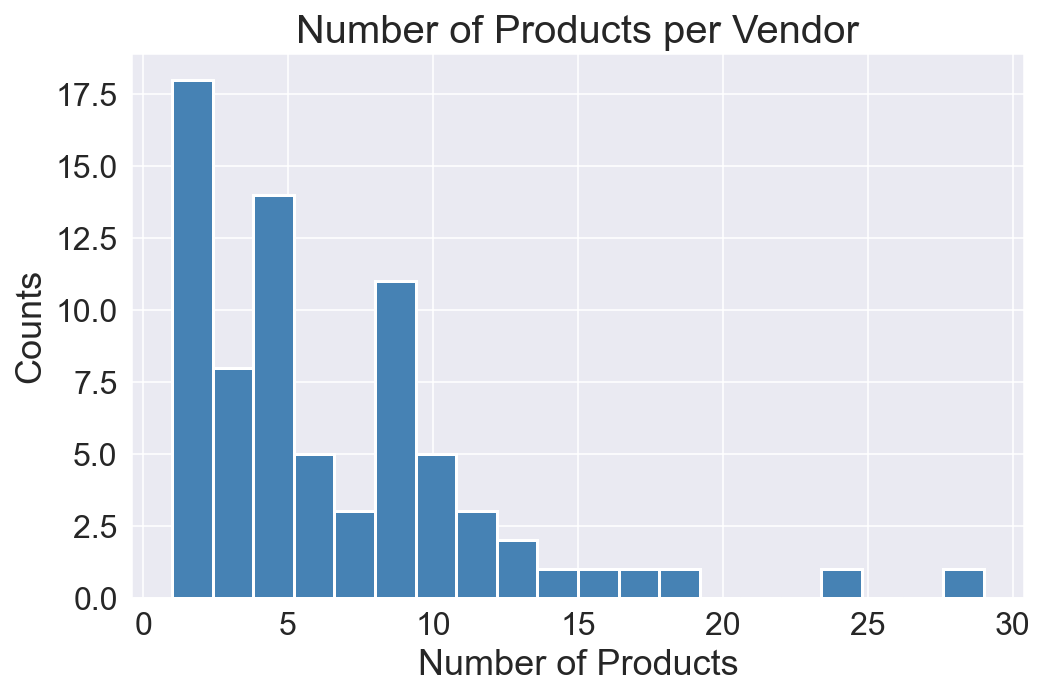

In [19]:
df['Vendor_id'].value_counts().hist(figsize=(8, 5),
                          bins=20,
                          color='steelblue',
                          linewidth=1.5);
plt.title('Number of Products per Vendor')
plt.xlabel('Number of Products')
plt.ylabel('Counts')

In [20]:
df['Country'].value_counts()

TW    487
IT      1
Name: Country, dtype: int64

In [21]:
df.drop(columns = 'Country', inplace = True)

## Categorical variable

In [22]:
df['Main_Category'].value_counts()

agritech                        280
agrilivestock                   116
agrifresh                        53
sustainable-aquatic-products     25
fish-farming                     14
Name: Main_Category, dtype: int64

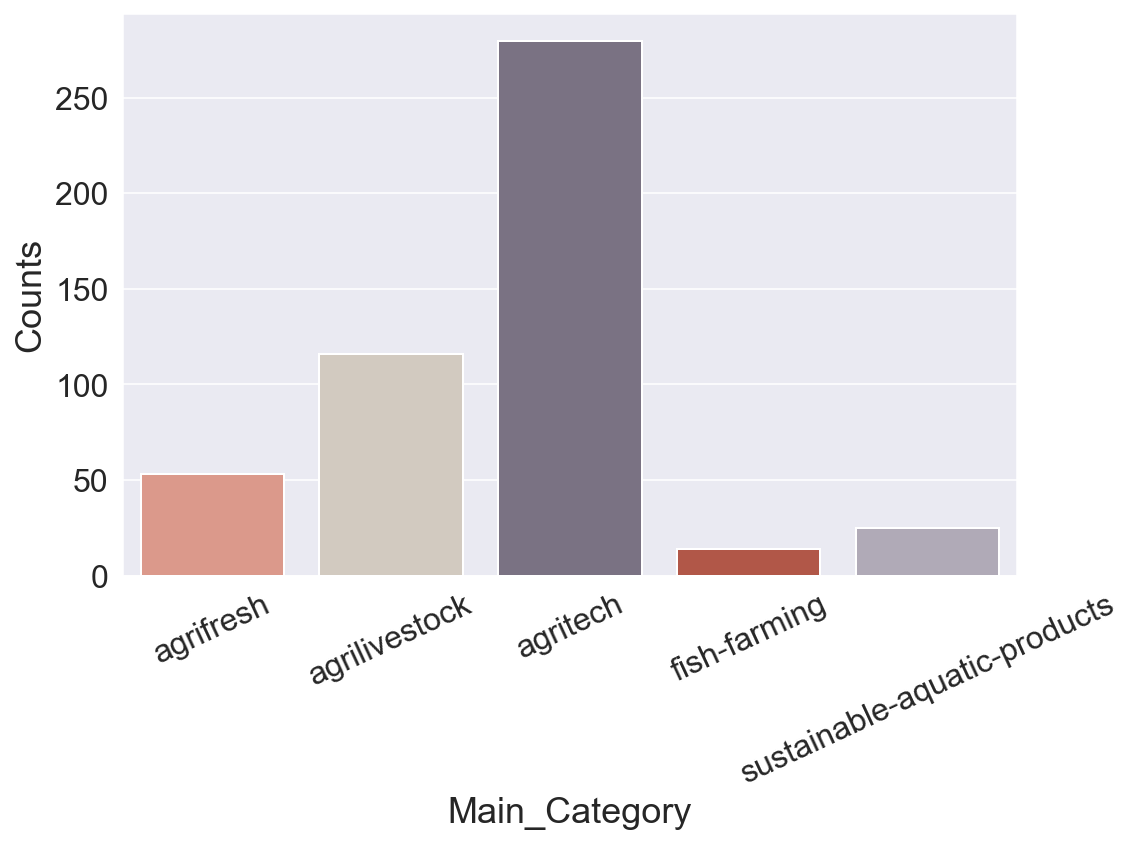

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='Main_Category', data=df, palette=colors_cat, width=0.8)
plt.ylabel('Counts')
plt.xticks(rotation=25)
plt.tight_layout();

For certain subgroups, there are only a few products.

In [24]:
df['Sub_Category'].value_counts()

Agritech-Other                                           129
Agrilivestock-Other                                       50
Labour-Saving-Machinery-and-Equipment                     40
Livestock-Feed-and-Additives                              37
Garden-Materials                                          29
Sustainable-Aquatic-Products-Other                        24
Intelligent-Detection-System-and-Equipment                23
Ventilation-Equipment                                     21
Organic-Fertilizer                                        15
Agrifresh-Other                                           13
Agricultural-Processing-Machinery                         12
Seedlings-and-Flower-Seed                                 11
Plant-Disease-and-Pest-Control                            11
AIoT-Intelligent-Cold-Chain-Logistic-Solution             10
Refrigeration-and-Freezing-Equipment                      10
Fish-Farming-Other                                         9
Intelligent-Temperature-

## Text Description

In [25]:
df['Description'].head()

0    ‚óèÂÖ®Â§©ÂÄôÁí∞‰øùËÅö‰πôÁÉØËÜ†Â∏∂\n \n ‚óèÈ´òÁ≤òÂêàÊ∫∂ÂäëÂûã‰∏ôÁÉØÈÖ∏Á≤òÂêàÂäë \n \n ‚óèÈÅ©Áî®ÊñºÂ§ßÁØÑÂúçÁöÑÊà∂...
1    ‚óè C+ÈÄöÁî®ÂûãÂåÖË£ùËÜ†Â∏∂\n \n ‚óèÂÖ®‰∏ñÁïåÁ¨¨‰∏ÄÂÄãÁîüÁâ©ÂèØÂàÜËß£OPP ÂåÖË£ùËß£Ê±∫ÊñπÊ°àÔºåÂèØËàá‰∏ÄËà¨PP...
2    ‚óèËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂\n \n ‚óèÈ´òÂâùÈõ¢Âäõ\n \n ‚óèÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù \n \n ‚óèÁí∞...
3                             ËªüË≥™‰∫ÆÈù¢PVC ËÜ†Â∏∂„ÄÅÈ´òÂâùÈõ¢Âäõ„ÄÅÈÅ©ÂêàÁî®ÊñºÊ¢®Â≠êÊé•Êûù
4                             È´òÈªèËëóÂäõ„ÄÅÁÑ°Ê∫∂Âäë„ÄÅÁí∞Â¢ÉÂèãÂñÑ„ÄÅÈ´ò‰øùÊåÅÂäõ„ÄÅÈ´òÊ©üÊ¢∞Âº∑Â∫¶
Name: Description, dtype: object

In [26]:
df['Description_en'].head()

0    ‚óèAll-weather environmentally friendly polyethy...
1    ‚óè C+ general purpose packing tape\n \n ‚óèThe wo...
2    ‚óèSoft and glossy finished PVC tape\n \n ‚óèHigh ...
3    Soft and glossy finished PVC tape„ÄÅHigh unwindi...
4    Strong Adhesion„ÄÅSolvent-Free„ÄÅECO-Friendly„ÄÅHeav...
Name: Description_en, dtype: object

# Data Preprocessing

We will create four embeddings:

* Main Category embedding 
* Subcategory embedding 
* Product Name embedding (tw)
* Product Name embedding (en)
* Product Description embedding (tw)
* Product Description embedding (en)

To generate accurate recommendation, we determine the weights of these embeddings based on their importance.

In [27]:
arr = [1, 4, 1, 25, 1, 13]
alpha = arr/np.sum(arr)

## Categorical Features Encoding

Utilize one-hot encoding to encode the `Main_Category` and `Sub_Category` variables, enabling us to analyze the similarity between vectors in the further analysis

In [28]:
main_encode = pd.get_dummies(df['Main_Category'], drop_first=False)*alpha[0]
sub_encode = pd.get_dummies(df['Sub_Category'], drop_first=False)*alpha[1]
category_encode = np.concatenate((main_encode, sub_encode), axis=1)
category_encode.shape

(488, 36)

## Text Encoding

Utilize Sentence-BERT, which is based on Siamese BERT-Networks, to generate embeddings for both `Product_Name` and `Description`, as described in the paper ["Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks"](https://arxiv.org/pdf/1908.10084.pdf) (Reimers & Gurevych, 2019).

Change English product name into lowercase to have a consistent structure

In [29]:
df['Product_Name_en'] = df['Product_Name_en'].apply(lambda x: x.lower())

In [30]:
model_en = SentenceTransformer('all-mpnet-base-v2')
model_tw = SentenceTransformer('paraphrase-distilroberta-base-v1')
product_em_tw_ = model_tw.encode(df['Product_Name'])
product_em_en_ = model_en.encode(df['Product_Name_en'])
des_em_tw_ = model_tw.encode(df['Description'])
des_em_en_ = model_en.encode(df['Description_en'])

Normalize the embeddings to mitigate the influence of magnitude on similarity

In [31]:
product_em_tw = normalize_embedding(product_em_tw_) * alpha[2]
product_em_en = normalize_embedding(product_em_en_) * alpha[3]
des_em_tw = normalize_embedding(des_em_tw_) * alpha[4]
des_em_en = normalize_embedding(des_em_en_) * alpha[5]

In [32]:
keywords_en_em = np.concatenate((product_em_en, des_em_en), axis = 1)

In [33]:
# product_em = np.concatenate((product_em_tw, product_em_en), axis=1) * alpha[2]
# des_em = np.concatenate((des_em_tw, des_em_en), axis=1)  * alpha[3]
# text_em = np.concatenate((product_em, des_em), axis=1)

In [34]:
text_em = np.concatenate((product_em_en, des_em_en, product_em_tw, des_em_tw), axis=1)
text_em.shape

(488, 3072)

Combine category embedding and text embedding

In [35]:
embedding = np.concatenate((category_encode, text_em), axis=1)
embedding.shape

(488, 3108)

In [36]:
df.loc[1:100,['Product_Name','Product_Name_en','Description_en']]

Product_Name  \
1                     C+ ÁîüÁâ©ÂèØÂàÜËß£ËÜ†Â∏∂   
2                       PVC Êé•Ê¢®ËÜ†Â∏∂   
3                       PVC Êé•Ê¢®ËÜ†Â∏∂   
4                        ÂõûÊî∂PETËÜ†Â∏∂   
5                       Áí∞‰øùÂûãÁâõÁöÆÁ¥ôËÜ†Â∏∂   
6                    ÂõûÊî∂PET Ê∞¥ËÜ† ËÜ†Â∏∂   
7                            Ê∞¥Á∞æÁâá   
8                            Á¥ôË≠∑Ëßí   
9                            Ê∞¥Á∞æÁâá   
10                           Ê∞¥Á∞æÁâá   
11                   Á¥ôË≠∑Ëßí„ÄÅË≠∑ËßíÁ¥ô„ÄÅÁ¥ôÈÇäÊ¢ù   
12                 Â•àÁ±≥Ê∞£Ê≥° Â¢ûÊ∞ßÊ∞¥Ë≥™ÁÆ°ÁêÜÊñπÊ°à   
13                   Áâ©ËÅØÁ∂≤Ë®≠ÊñΩÁí∞ÊéßËß£Ê±∫ÊñπÊ°à   
14                  ÂÖâÁ©çÂÄº Á≤æÊ∫ñÊæÜÁÅåËß£Ê±∫ÊñπÊ°à   
15                       Êô∫ÊÖßÊæÜÁÅåÊéßÂà∂Âô®   
16                        ÈúπÈùÇÁ©†Á†îÈÖíËóè   
17                    ÊôÇÊ∞£Á¥îÈüª(Á≥ôÁ±≥ÁôΩÈÖí)   
18                          Á¥ÖËóúÁôΩÈÖí   
19                          ÁôæËä±Âß¨ÈÖí   
20                         ‰∏πÂèÉËä±ËëâÈÖí   
21                     Á¶èÊ∞£Ê∞∏Ë±ê(Ëë°ËêÑÈÖí)   
22                      ÂíåÊ∞£ÂÖÉÈÖí(‰∏πÂèÉ)   
23                  Â§©ÁôíÁ∫ñÁ©ÄÊ£í(ÂéüÂë≥/Êµ∑Ëãî)   
24                       Â§©Áôí‰∏πÂèÉÂãÅËä±Ëå∂   
25                       Â§©ÁôíÁ≥ôÁ±≥Â†ÖÊûúÈÖ•   
26                    Â§©ÁôíÁ≥ôÁ±≥ÂéüÊºø(ÂéüÂë≥)   
27                    Â§©ÁôíÁ≥ôÁ±≥ÂéüÊºø(Êû∏Êùû)   
28              Â§©Áôí‰∫îÁîüÁ±≥(Á≥ôÁ±≥/ËÉöËäΩÁ±≥/ÁôΩÁ±≥)   
29                        Â§©Áôí‰∫îÁîüÂÖÉÊ∂≤   
30                         Â§©ÁôíËä±ËçâËå∂   
31                           ÈæçÊÆ∫ÁêÉ   
32                 Êô∫ÊÖßËõãÈõûÈ£ºÈ§äÁ≥ªÁµ±-ÈòøÁàæÂçëÊñØ   
33                            ÁêÉÈú∏   
34                           ÈùíÊò•Èú≤   
35                       ÊûúËêåÂÑ™ 350   
36                       Ëä±Â¶çÁæé 601   
37                       ÊûúÂ¶çÁæé 380   
38                       ÂÖ®Ê§çËÉΩ 100   
39                       ÊúâÊûúÁîú 390   
40                       ÈÄüÁõäÊ†π 110   
41                       Ëî¨ÊûúÂº∑ 370   
42                  HOCL Ê¨°Ê∞ØÈÖ∏ÁîüÊàêË®≠ÂÇô   
43          EnvirolyteÊ¨°Ê∞ØÈÖ∏ÊÆ∫ËèåÈõªËß£Ê∞¥Á≥ªÁµ±   
44                        Â§öÂäüËÉΩÁ£®ÂàÄÊ©ü   
45                            ÂâÅÂàÄ   
46                  30cm ÁæéÂºèÂ±†ÂÆ∞‰øÆÂâ≤ÂàÄ   
47                      18cm ÁâáÈ≠öÂàÄ   
48                      18cm ÂâùÁöÆÂàÄ   
49                      15cm ÂâîÈ™®ÂàÄ   
50                     15cm ÂΩéÂâîÈ™®ÂàÄ   
51                      24cm ÂâùÁ≠ãÂàÄ   
52                    14.5cm ÂâîÈ™®ÂàÄ   
53                       Ëæ≤Ê•≠Á¥ÄÈåÑAPP   
54                        Ëæ≤Ê•≠Êï∏ÊìöÂàÜÊûê   
55                     Ëæ≤Âú∞Ê∞£ÂÄôÁöÑÂç≥ÊôÇÁõ£Ê∏¨   
56                      ËúÇÂ∑¢- Ëß£Ê±∫ÊñπÊ°à   
57                        ËúÇÂ∑¢Êï∏ÊìöÁßëÊäÄ   
58                 Áâ©ËÅØÁ∂≤ÊúçÂãô-ÂÆπÊòìÈñãÁôºÂíåÁÆ°ÁêÜ   
59            IoTConnect-Â§öÂÄãSDKÈÅ∏È†Ö   
60          IoTConnect--Âú®Èõ≤Á´ØÂØ¶ÁèæÈõ∂ÁºñÁ®ã   
61   ÂÆâÂØåÂà©IotConnect-Âà©Áî®AzureÁâ©ËÅØÁ∂≤ÁöÑÂÑ™Âã¢   
62                     AIoT‰∏ÄÁ´ôÂºèÊúçÂãô   
63                       Ëî¨ÊûúË™ûÈü≥ÂàÜÁ¥öÊ©ü   
64                       ÈáçÈáèÈ°ØÁ§∫ÊéßÂà∂Âô®   
65                       ÈáçÈáèÈ°ØÁ§∫ÊéßÂà∂Âô®   
66                       ÈáçÈáèÈ°ØÁ§∫ÊéßÂà∂Âô®   
67                     ÈáçÈáèÈ°ØÁ§∫Ê™¢Ê∏¨ÊéßÂà∂Âô®   
68                       ÈáçÈáèÈ°ØÁ§∫ÊéßÂà∂Âô®   
69                       ÈáçÈáèÈ°ØÁ§∫ÊéßÂà∂Âô®   
70                     ÂñÆÁß§Ëá™ÂãïÈáçÈáèÂ°´ÂÖÖÊ©ü   
71                         ÈáçÈáèÊ™¢Ê∏¨Ê©ü   
72                BDI-2006 ÈáçÈáèÈ°ØÁ§∫Âô®   
73                       ÈáçÈáèÊ™¢Ê∏¨ÈÅ∏Âà•Ê©ü   
74            STHP-1000 Â§™Á©∫ÂåÖË®àÈáèÂ°´ÂÖÖÊ©ü   
75       STHP-800 Ëá™ÂãïË®àÈáèÂ°´ÂÖÖÊ©ü (‰∏çÈèΩÈãºÂûã)   
76                         Ë®àÈáèÂ°´ÂÖÖÊ©ü   
77                  Â°ëÁí∞Áúü¬Æ‚îÇ„ÄäÂæ™Áí∞Â•ΩÁõÜÂèã„Äã   
78                          Ê§çÂæ™Áí∞ÁõÜ   
79                        Ê∞¥Ê∫êÂØ∂ËÇ≤Ê®πÁõÜ   
80              ËúÇË†üÂ∏É(Âü∫Êú¨Ê¨æ/‰øùÈÆÆÁΩ©/Ë∂ÖÂ•ΩËìã)   
81                         Ê®πÊ†π‰øùË≠∑Â•ó   
82                      3Ëã±ÂêãÊ®πÊ†πÈÄèÊ∞£ÁÆ°   
83             

In [57]:
eb = normalize_embedding(model_en.encode('food'))
eb = np.concatenate((eb, eb), axis = 0)
row_idx = []
score_ls = []
rec_k_dic = util.semantic_search(eb, keywords_en_em, top_k=10)[0]
for item in rec_k_dic:
    row_idx.append(item['corpus_id'])
    score_ls.append(round(item['score'],3))
df.loc[row_idx,['Product_id','Sub_Category','Product_Name']]

Product_id                                   Sub_Category  \
390  CU0008289202                                 Agritech-Other   
469  CU0103327702                                 Agritech-Other   
54   CU0106103902  AIoT-Intelligent-Cold-Chain-Logistic-Solution   
90   CU0005376502                   Livestock-Feed-and-Additives   
392  CU0008289204                                 Agritech-Other   
299  CU0001046724          Labour-Saving-Machinery-and-Equipment   
139  CU0106395604                             Organic-Fertilizer   
123  CU0103365202                   Livestock-Feed-and-Additives   
410  CU0102854703                                 Agritech-Other   
118  CU0101721507             Sustainable-Aquatic-Products-Other   

        Product_Name  
390             ÊúâÊ©üËî¨Êûú  
469       ÁîüÈÆÆËî¨ËèúÔºøÂ±•Ê≠∑ÁâõÁï™ËåÑ  
54            Ëæ≤Ê•≠Êï∏ÊìöÂàÜÊûê  
90             ÊÑèÂµê‰π≥ÂåñÂäë  
392          Âú∞‰∏≠Êµ∑ÊñôÁêÜËî¨Êûú  
299        ‰∫∫Â∑•Êô∫ËÉΩÈÄÅÈ§êÊ©üÂô®‰∫∫  
139          Ê∞∏Á∂†ÁâåÊ¥ªÁ∂†ÁôºÊûú  
123              ÈÄüÁõäÁîü  
410  Êú¨Â™íÂêàÁÆ°ÈÅìÊèê‰æõËæ≤Áî¢Ê•≠ËÄÖ3È†Ö‰æøÂà©  
118              Ëä≠Ê®Ç‰πæ

In [38]:
# Evaluate differnece by norm
# diff = product_em_en_[4] - eb
# print('Norm:',np.linalg.norm(diff))

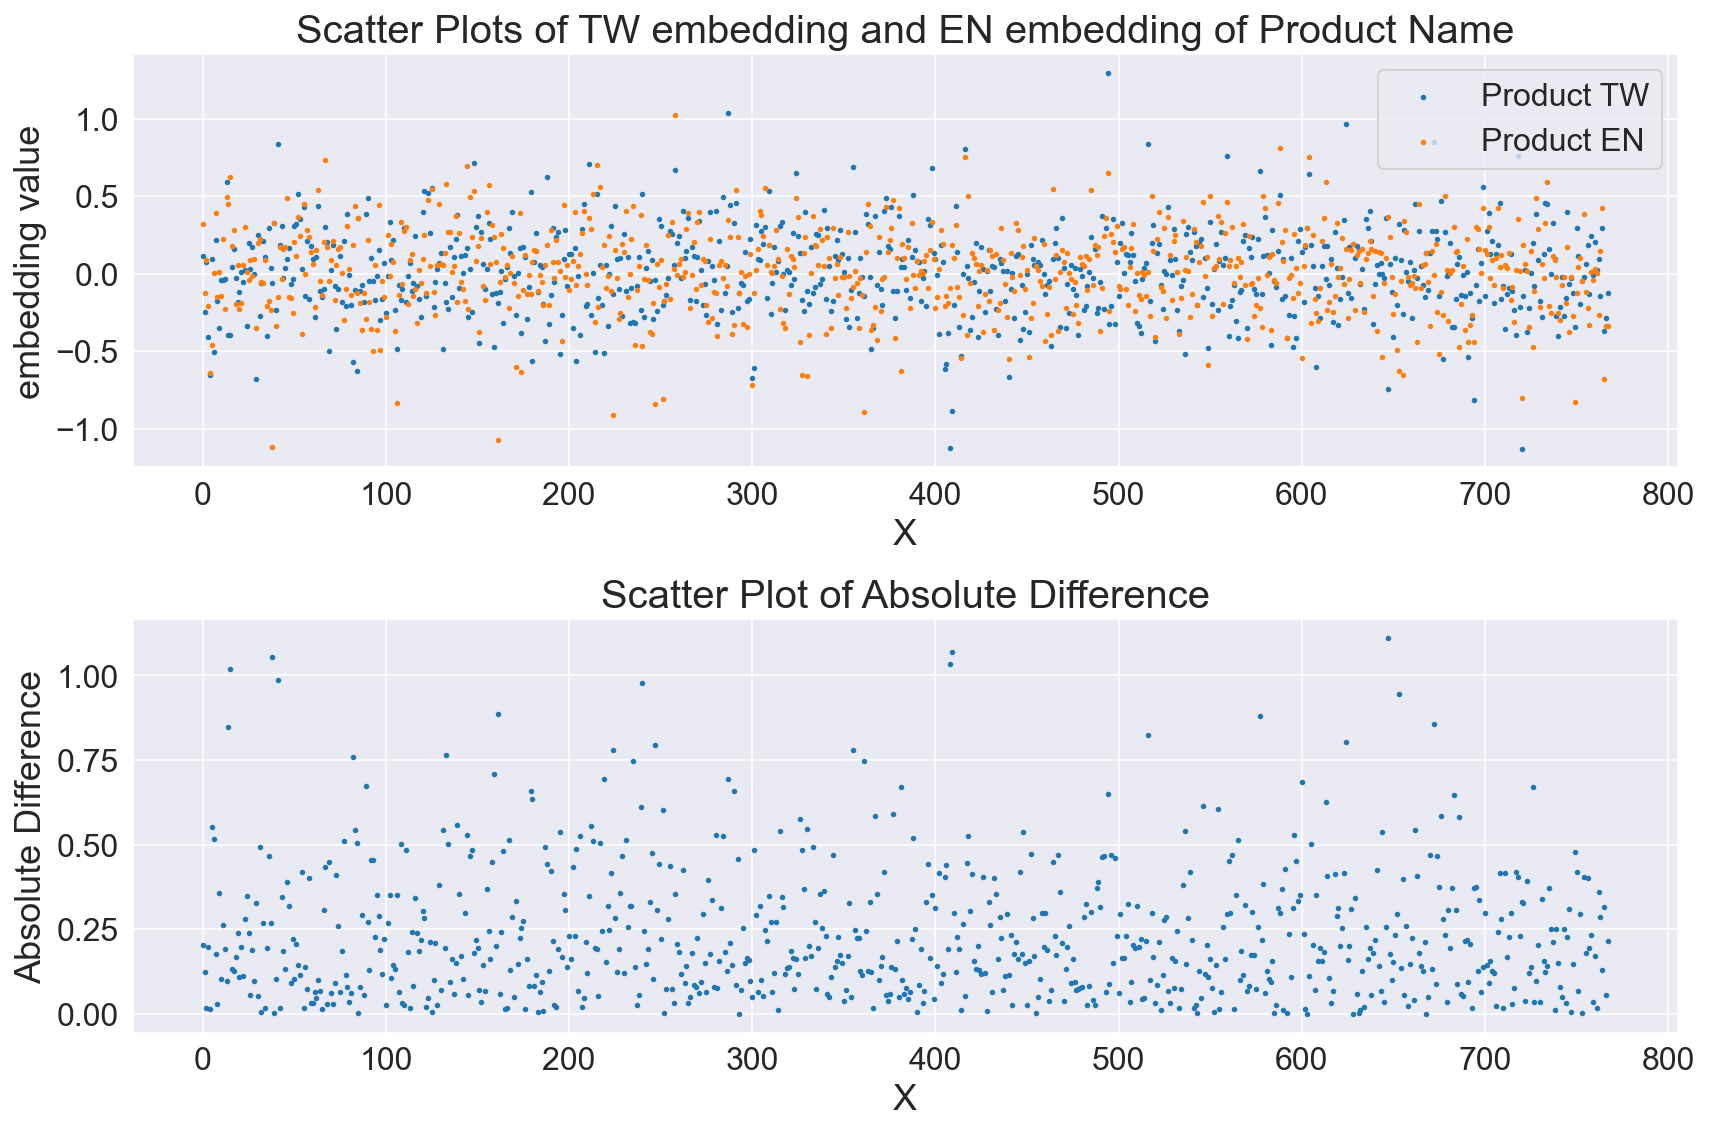

In [40]:
em_tw_plot = model_tw.encode(df['Product_Name'])
em_en_plot = model_tw.encode(df['Product_Name_en'])

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
x = np.arange(0,len(em_tw_plot[0]),1)
diff = np.abs(em_tw_plot[0] - em_en_plot[0])

# Plot the scatter plots on the second subplot
ax1.scatter(x, em_tw_plot[0], s=3, label='Product TW')
ax1.scatter(x, em_en_plot[0], s=3, label='Product EN')
ax1.set_xlabel('X')
ax1.set_ylabel('embedding value')
ax1.set_title('Scatter Plots of TW embedding and EN embedding of Product Name')
ax1.legend()

# Plot the scatter plot on the first subplot
ax2.scatter(x, diff, s=3)
ax2.set_xlabel('X')
ax2.set_ylabel('Absolute Difference')
ax2.set_title('Scatter Plot of Absolute Difference')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Store embedding as a dictionary type in the file

Map the embedding to the corresponding product_id in a dictionary structure and store it

In [41]:
# keys = df['Product_id']
# # embedding = torch.tensor(embedding)
# id_embedding_dict = dict(zip(keys, embedding))
# file_name = '.\embedding\item_embedding.pkl'
# with open(file_name, "wb") as file:
#     pickle.dump(id_embedding_dict, file)

In [42]:
# product_em_en_dict = dict(zip(keys, product_em_en))
    
# file_name = '.\embedding\product_em_en.pkl'
# with open(file_name, "wb") as file:
#     # Serialize and write the dictionary to the file
#     pickle.dump(product_em_en_dict, file)

In [43]:
# des_em_en_dict = dict(zip(keys, des_em_en))
    
# file_name = '.\embedding\des_em_en.pkl'
# with open(file_name, "wb") as file:
#     # Serialize and write the dictionary to the file
#     pickle.dump(des_em_en_dict, file)

In [44]:
# keywords_en_em_dict = dict(zip(keys, keywords_en_em))
    
# file_name = '.\embedding\keywords_en_em.pkl'
# with open(file_name, "wb") as file:
#     # Serialize and write the dictionary to the file
#     pickle.dump(keywords_en_em_dict, file)

Load the dictionary of embedding

In [45]:
# file_name = '.\embedding\item_embedding.pkl'
# with open(file_name, "rb") as file:
#     id_embedding_dict = pickle.load(file)

## Store preprocessed data as list([dict]) for use in Elasticsearch

In [46]:
# df_dict = df[['Product_id', 'Product_Name', 'Product_Name_en', 'Description', 'Description_en']]
# # Create a dictionary mapping the old column names to the new column names
# column_mapping = {'Product_Name': 'Product_Name_tw',
#                   'Description': 'Description_tw'}
# # Convert the dataframe to dictionaries
# df_dict = [{column_name: df_dict.loc[index, column_name] for column_name in df_dict.columns} for index in range(df_dict.shape[0])]
# file_name = '.\Data\df_dict.pkl'
# with open(file_name, "wb") as file:
#     # Serialize and write the dictionary to the file
#     pickle.dump(df_dict, file)

# Recommendation Model Building

## Experiment and Parameter Tuning

Sample items in each category to evaluate

In [47]:
# idx_list = []
# for colname in df['Sub_Category'].unique():
#     condition = df['Sub_Category'] == colname
#     idx = df[condition].sample(n=1).index[0]
#     idx_list.append(idx)
    
# sample_df = df.iloc[idx_list].drop(columns=['Product_id','Vendor_id','Country'])

Use all items to evaluate

In [48]:
idx_list = np.arange(0, df.shape[0])

Recommend items by calculating the cosine similarity between the item embeddings. Output the results into a cell file and save them in an Excel file.

In [49]:
# output_file = './Data/Rec-Agr-{}.xlsx'.format(arr)
# blank_row_color = 'FFFF00'  # Yellow color code

# # Load the existing workbook or create a new one
# try:
#     workbook = openpyxl.load_workbook(output_file)
# except FileNotFoundError:
#     workbook = openpyxl.Workbook()

# # Save the workbook
# workbook.save(output_file)

# # Get the default sheet name (usually "Sheet1")
# sheet_name = workbook.sheetnames[0]

# # Create a Pandas Excel writer using openpyxl engine and append mode
# writer = pd.ExcelWriter(output_file, engine='openpyxl', mode='a')

# # Assign the existing workbook to the writer
# writer.book = workbook

# # Select the default sheet
# writer.sheets = {sheet_name: workbook[sheet_name]}

# # Keep track of the row index for writing data
# current_row = writer.sheets[sheet_name].max_row + 1

# # Generate recommendations for each sample index
# for sample_idx in idx_list:
#     row_idx = []
#     score_ls = []
#     rec_k_dic = util.semantic_search(embedding[sample_idx], embedding, top_k=10)[0]
#     for item in rec_k_dic:
#         row_idx.append(item['corpus_id'])
#         score_ls.append(round(item['score'],3))  
# #     select_idx = np.insert(row_idx, 0, sample_idx) # Put the input item as a reference
#     output_df = df.iloc[row_idx]
#     output_df['Score'] = score_ls

#     # Set the cell color for the first row behind the blank row
#     sheet = writer.book[sheet_name]
#     for col in range(1, len(output_df.columns) + 10):
#         cell = sheet.cell(row=current_row + 1, column=col)
#         cell.fill = openpyxl.styles.PatternFill(fill_type='solid', fgColor=blank_row_color)

#     # Write the DataFrame to Excel
#     output_df.to_excel(writer, sheet_name=sheet_name, startrow=current_row, index=True, header=False)

#     # Update the current row index for the next set of recommendations
#     current_row += len(output_df) + 1  # Add 1 for the blank row

# # Save the Excel file
# writer.save()
# workbook.close()
# writer.close()

## Recommend Top K

In [50]:
# product_id = 'CU0004601801' # tape
# product_id = 'CU0009108101' # alcohol
# product_id = 'CU0004414408' # thermometer
product_id = 'CU0001452809'

k = 5
threshold = 0.75
row_index = df[df['Product_id'] == product_id].index
df.iloc[row_index]

Product_id Product_Name   Vendor_id  Main_Category  \
262  CU0001452809         Ê≠£Â£ìÈ¢®Ê©ü  CU00014528  agrilivestock   

              Sub_Category                                        Description  \
262  Ventilation-Equipment  1.Áí∞‰øùÁØÄËÉΩ+ËàíÈÅ©ÂÆâÂÖ®\n \n 2.‰øùË≠∑Áí∞Â¢É+ÈÄ†Á¶èÂãûÂ∑•\n \n 3.ÊèêÈ´òÂ∑•‰ΩúÊïàÁéáÊèêÈ´òÁî¢ËÉΩ...   

    Product_Name_en                                     Description_en  
262             fan  1.Environment control and saving energy.\n \n ...

In [51]:
rec_pd_id_ls, rec_score_ls, rec_row_idx = recommend_top_k(product_id, k, 0.75)
for i in range(len(rec_pd_id_ls)):
    print('Product_id:', rec_pd_id_ls[i],'Score:', rec_score_ls[i])
df.iloc[rec_row_idx]

Product_id: CU0001452808 Score: 1.0
Product_id: CU0001452806 Score: 1.0
Product_id: CU0001452807 Score: 0.886
Product_id: CU0001452801 Score: 0.886
Product_id: CU0001452805 Score: 0.853


Product_id Product_Name   Vendor_id  Main_Category  \
261  CU0001452808         Ê≠£Â£ìÈ¢®Ê©ü  CU00014528  agrilivestock   
259  CU0001452806          Èù¢ÊùøÊâá  CU00014528  agrilivestock   
260  CU0001452807          ÁôæËëâÊâá  CU00014528  agrilivestock   
254  CU0001452801          ÁôæËëâÊâá  CU00014528  agrilivestock   
258  CU0001452805        Ë∂ÖÁ¥öÂ§ßÂêäÊâá  CU00014528  agrilivestock   

              Sub_Category                                        Description  \
261  Ventilation-Equipment  1.Áí∞‰øùÁØÄËÉΩ+ËàíÈÅ©ÂÆâÂÖ®\n \n 2.‰øùË≠∑Áí∞Â¢É+ÈÄ†Á¶èÂãûÂ∑•\n \n 3.ÊèêÈ´òÂ∑•‰ΩúÊïàÁéáÊèêÈ´òÁî¢ËÉΩ...   
259  Ventilation-Equipment  1.Áí∞‰øùÁØÄËÉΩ+ËàíÈÅ©ÂÆâÂÖ®\n \n 2.‰øùË≠∑Áí∞Â¢É+ÈÄ†Á¶èÂãûÂ∑•\n \n 3.ÊèêÈ´òÂ∑•‰ΩúÊïàÁéáÊèêÈ´òÁî¢ËÉΩ...   
260  Ventilation-Equipment  1.Áí∞‰øùÁØÄËÉΩ+ËàíÈÅ©ÂÆâÂÖ®\n \n 2.‰øùË≠∑Áí∞Â¢É+ÈÄ†Á¶èÂãûÂ∑•\n \n 3.ÊèêÈ´òÂ∑•‰ΩúÊïàÁéáÊèêÈ´òÁî¢ËÉΩ...   
254  Ventilation-Equipment  1.Áí∞‰øùÁØÄËÉΩ+ËàíÈÅ©ÂÆâÂÖ®\n \n 2.‰øùË≠∑Áí∞Â¢É+ÈÄ†Á¶èÂãûÂ∑•\n \n 3.ÊèêÈ´òÂ∑•‰ΩúÊïàÁéáÊèêÈ´òÁî¢ËÉΩ...   
258  Ventilation-Equipment                               Êèê‰æõÊ∂ºÁàΩÁöÑÂ∑•‰ΩúÁí∞Â¢É‰øÉ‰ΩøÊèêÂçáÂ∑•‰ΩúÊïàÁéá„ÄÅÁî¢ËÉΩ   

    Product_Name_en                                     Description_en  
261             fan  1.Environment control and saving energy.\n \n ...  
259             fan  1.Environment control and saving energy.\n \n ...  
260     shutter fan  1.Environment control and saving energy.\n \n ...  
254     shutter fan  1.Environment control and saving energy.\n \n ...  
258     ceiling fan  Supply cooling working environment to advance ...

# Future Development

- How can the performance and accuracy of the recommendation model be evaluated and measured in the context of the exhibition industry, considering the absence of explicit labels?
- Overall, the recommendations are generally accurate. However, the model occasionally generates some irrelevant items for specific products.


# Conclusions

The expected outcome is an item-based recommendation model for the dynamic exhibition industry that significantly enhances attendees' ability to find relevant products efficiently. By addressing the difficulties related to unsupervised learning, lack of quantitative features, and reliance on text information, the model aims to identify key product features, effectively utilize them for recommendations, and employ suitable similarity analysis techniques. Through these methods, the model strives to provide accurate and relevant recommendations, improving the overall experience for attendees.